# DoWhy: Different estimation methods for causal inference
This is a quick introduction to the DoWhy causal inference library.
We will load in a sample dataset and use different methods for estimating the causal effect of a (pre-specified)treatment variable on a (pre-specified) outcome variable.

We will see that not all estimators return the correct effect for this dataset.

First, let us add the required path for Python to find the DoWhy code and load all required packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import logging

import dowhy
from dowhy import CausalModel
import dowhy.datasets 

Now, let us load a dataset. For simplicity, we simulate a dataset with linear relationships between common causes and treatment, and common causes and outcome. 

Beta is the true causal effect. 

In [3]:
data = dowhy.datasets.linear_dataset(beta=10,
        num_common_causes=5, 
        num_instruments = 2,
        num_treatments=1,
        num_samples=10000,
        treatment_is_binary=True,
        outcome_is_binary=False,
        stddev_treatment_noise=10)
df = data["df"]
df

,Z0,Z1,W0,W1,W2,W3,W4,v0,y
0,1.0,0.921933,-0.909163,2.111430,0.218589,-1.848638,-0.019158,True,6.465303
1,1.0,0.437687,-0.567028,2.623724,0.402635,-1.859093,-0.212637,False,-0.409387
2,1.0,0.165806,-0.318790,0.515367,-0.463976,0.802628,1.067856,True,17.155130
3,1.0,0.492576,-1.400036,0.769622,0.187717,0.697907,0.176179,True,9.432517
4,1.0,0.973454,0.055561,1.508183,0.502427,0.899755,0.194425,True,21.038799
...,...,...,...,...,...,...,...,...,...
9995,1.0,0.721289,-0.358580,0.583704,0.321807,-0.173815,0.750440,True,13.465028
9996,1.0,0.467391,-0.809530,1.315182,2.032384,-2.393138,-1.243522,False,-10.261690
9997,0.0,0.790983,0.628105,1.130239,3.158609,-0.926168,0.953203,True,23.373313
9998,1.0,0.290353,-1.956492,1.055923,0.756147,-0.829631,2.212745,True,11.550253


Note that we are using a pandas dataframe to load the data.

## Identifying the causal estimand

We now input a causal graph in the DOT graph format.

In [4]:
# With graph
model=CausalModel(
        data = df,
        treatment=data["treatment_name"],
        outcome=data["outcome_name"],
        graph=data["gml_graph"],
        instruments=data["instrument_names"]
        )

In [5]:
model.view_model()

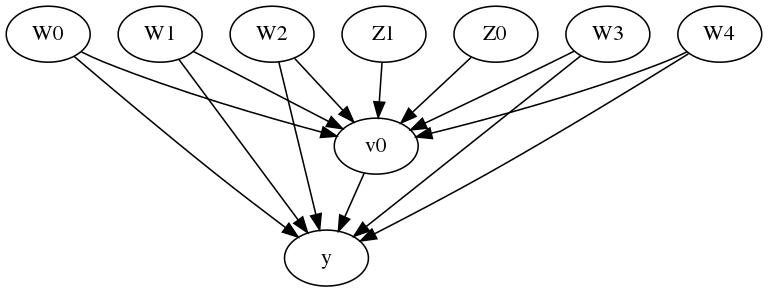

In [6]:
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

We get a causal graph. Now identification and estimation is done. 

In [7]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W0,W4,W2,W1,W3))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W4,W2,W1,W3,U) = P(y|v0,W0,W4,W2,W1,W3)

### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z0, Z1])*Derivative([v0], [Z0, Z1])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z0,Z1})
Estimand assumption 2, Exclusion: If we remove {Z0,Z1}→{v0}, then ¬({Z0,Z1}→y)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



## Method 1: Regression

Use linear regression.

In [8]:
causal_estimate_reg = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression",
        test_significance=True)
print(causal_estimate_reg)
print("Causal Estimate is " + str(causal_estimate_reg.value))

linear_regression


{'control_value': 0, 'treatment_value': 1, 'test_significance': True, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W0,W4,W2,W1,W3))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W4,W2,W1,W3,U) = P(y|v0,W0,W4,W2,W1,W3)

## Realized estimand
b: y~v0+W0+W4+W2+W1+W3
Target units: ate

## Estimate
Mean value: 9.999505048564053
p-value: [0.]

Causal Estimate is 9.999505048564053


## Method 2: Distance Matching

Define a distance metric and then use the metric to match closest points between treatment and control.

In [9]:
causal_estimate_dmatch = model.estimate_effect(identified_estimand,
                                              method_name="backdoor.distance_matching",
                                              target_units="att",
                                              method_params={'distance_metric':"minkowski", 'p':2})
print(causal_estimate_dmatch)
print("Causal Estimate is " + str(causal_estimate_dmatch.value))

distance_matching


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W0,W4,W2,W1,W3))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W4,W2,W1,W3,U) = P(y|v0,W0,W4,W2,W1,W3)

## Realized estimand
b: y~v0+W0+W4+W2+W1+W3
Target units: att

## Estimate
Mean value: 11.00324959794003

Causal Estimate is 11.00324959794003


## Method 3: Propensity Score Stratification

We will be using propensity scores to stratify units in the data.

In [10]:
causal_estimate_strat = model.estimate_effect(identified_estimand,
                                              method_name="backdoor.propensity_score_stratification",
                                              target_units="att")
print(causal_estimate_strat)
print("Causal Estimate is " + str(causal_estimate_strat.value))

propensity_score_stratification


/home/amshar/python-environments/vpy38/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W0,W4,W2,W1,W3))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W4,W2,W1,W3,U) = P(y|v0,W0,W4,W2,W1,W3)

## Realized estimand
b: y~v0+W0+W4+W2+W1+W3
Target units: att

## Estimate
Mean value: 10.051770973262153

Causal Estimate is 10.051770973262153


## Method 4: Propensity Score Matching

We will be using propensity scores to match units in the data.

In [11]:
causal_estimate_match = model.estimate_effect(identified_estimand,
                                              method_name="backdoor.propensity_score_matching",
                                              target_units="atc")
print(causal_estimate_match)
print("Causal Estimate is " + str(causal_estimate_match.value))

propensity_score_matching


/home/amshar/python-environments/vpy38/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W0,W4,W2,W1,W3))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W4,W2,W1,W3,U) = P(y|v0,W0,W4,W2,W1,W3)

## Realized estimand
b: y~v0+W0+W4+W2+W1+W3
Target units: atc

## Estimate
Mean value: 10.212423020365232

Causal Estimate is 10.212423020365232


## Method 5: Weighting

We will be using (inverse) propensity scores to assign weights to units in the data. DoWhy supports a few different weighting schemes:
1. Vanilla Inverse Propensity Score weighting (IPS) (weighting_scheme="ips_weight")
2. Self-normalized IPS weighting (also known as the Hajek estimator) (weighting_scheme="ips_normalized_weight")
3. Stabilized IPS weighting (weighting_scheme = "ips_stabilized_weight")

In [12]:
causal_estimate_ipw = model.estimate_effect(identified_estimand,
                                            method_name="backdoor.propensity_score_weighting",
                                            target_units = "ate",
                                            method_params={"weighting_scheme":"ips_weight"})
print(causal_estimate_ipw)
print("Causal Estimate is " + str(causal_estimate_ipw.value))

propensity_score_weighting
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W0,W4,W2,W1,W3))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W4,W2,W1,W3,U) = P(y|v0,W0,W4,W2,W1,W3)

## Realized estimand
b: y~v0+W0+W4+W2+W1+W3
Target units: ate

## Estimate
Mean value: 10.864402146060451

Causal Estimate is 10.864402146060451


/home/amshar/python-environments/vpy38/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


## Method 6: Instrumental Variable

We will be using the Wald estimator for the provided instrumental variable.

In [13]:
causal_estimate_iv = model.estimate_effect(identified_estimand,
        method_name="iv.instrumental_variable", method_params = {'iv_instrument_name': 'Z0'})
print(causal_estimate_iv)
print("Causal Estimate is " + str(causal_estimate_iv.value))

instrumental_variable


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z0, Z1])*Derivative([v0], [Z0, Z1])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z0,Z1})
Estimand assumption 2, Exclusion: If we remove {Z0,Z1}→{v0}, then ¬({Z0,Z1}→y)

## Realized estimand
Realized estimand: Wald Estimator
Realized estimand type: nonparametric-ate
Estimand expression:
                                                              -1
Expectation(Derivative(y, Z0))⋅Expectation(Derivative(v0, Z0))  
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z0,Z1})
Estimand assumption 2, Exclusion: If we remove {Z0,Z1}→{v0}, then ¬({Z0,Z1}→y)
Estimand assumption 3, treatment_effect_homogeneity: Each unit's treatment ['v0'] is affected in the same way by common causes of ['v0'] and y
Estimand assumption 4, outcome_effect_homogeneity: Each unit's outcome y is affected in the same way by common c

## Method 7: Regression Discontinuity

We will be internally converting this to an equivalent instrumental variables problem.

In [14]:
causal_estimate_regdist = model.estimate_effect(identified_estimand,
        method_name="iv.regression_discontinuity", 
        method_params={'rd_variable_name':'Z1',
                       'rd_threshold_value':0.5,
                       'rd_bandwidth': 0.15})
print(causal_estimate_regdist)
print("Causal Estimate is " + str(causal_estimate_regdist.value))

regression_discontinuity
      local_rd_variable  local_treatment  local_outcome
1              0.437687            False      -0.409387
3              0.492576             True       9.432517
5              0.428471             True       7.975085
8              0.408115             True       9.478763
10             0.384428             True      17.627974
...                 ...              ...            ...
9989           0.378306             True      -2.096873
9990           0.583220            False      -5.798233
9991           0.506524             True      15.450128
9992           0.484825             True       1.642147
9996           0.467391            False     -10.261690

[3048 rows x 3 columns]
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z0, Z1])*Derivative([v0], [Z0, Z1])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z0,Z1})
Estim